In [320]:
import geopandas as gp
import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from shapely.geometry import Point, Polygon
import shapely
from adjustText import adjust_text
import math
from PIL import Image, ImageDraw, ImageFont
from os import path as Path
import contextily as ctx
import pandas as pd
from os import path
import requests
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import IMPERIAL_LENGTH

# TODO

- Add waypoints 
- Add scale
- Add legend 

# Extra
- Add parks, rivers, lakes, and landmarks
- Place boundaries based on route not total pop
- Adjust text no line overlap

# Map Elements
- Major and Minor Roadways
- Cities
- Landmarks
- Parks
- River and Steams
- Water Bodies

In [4]:
gpx_file = open('Leesburg Shamrock.GPX', 'r')
gpx = gpxpy.parse(gpx_file)

In [5]:
gpx_file2 = open('gmaps1.gpx', 'r')
gpx2 = gpxpy.parse(gpx_file2)

In [6]:
gpx_file3 = open('gmaps2.gpx', 'r')
gpx3 = gpxpy.parse(gpx_file3)

In [7]:
gmaps_gdf = gp.GeoDataFrame(columns=["geometry"], crs={'init' :'epsg:4326'})

for route in gpx2.tracks:
    for points in route.segments:
        for point in points.points:
#             print(point.name, point.latitude, point.longitude)
            gmaps_gdf = gmaps_gdf.append({
                "geometry": Point(point.longitude, point.latitude),

            }, ignore_index=True)
            
for route in gpx3.tracks:
    for points in route.segments:
        for point in points.points:
#             print(point.name, point.latitude, point.longitude)
            gmaps_gdf = gmaps_gdf.append({
                "geometry": Point(point.longitude, point.latitude),

            }, ignore_index=True)
    
gmaps_gdf = gmaps_gdf.to_crs(epsg=3857)

In [8]:
gdf = gp.GeoDataFrame(columns=["route", "name","geometry"], crs={'init' :'epsg:4326'})

points = []
for route in gpx.routes[:1]:
#     print(route.name)
    for point in route.points:
        points.append([point.latitude, point.longitude])
        print(point.name, point.latitude, point.longitude)
        gdf = gdf.append({
            "route": route.name,
            "name": point.name,
            "geometry": Point(point.longitude, point.latitude),
            
        }, ignore_index=True)
    
gdf = gdf.to_crs(epsg=3857)

17502 Battlefield Pkwy NE 39.12577064707875 -77.55639075301588
Cottage 39.11850898526609 -77.56321001797915
21095 Evergreen Mills Rd 39.03750887140632 -77.63606820255518
Gum Spring Rd 39.011111157014966 -77.75748250074685
25916 Auburn Farm Rd 38.90395221300423 -77.74209408089519
Hopewell Rd 38.86677377857268 -77.77046003378928
5645 Blantyre Rd 38.81812362000346 -77.75030868127942
Blackwell Rd and Unpaved Road 38.75849962234497 -77.78002738952637
Bike Stop 38.71363162994385 -77.79506921768188
9428 Springs Rd 38.662239164114 -77.863810043782
Jeffersonton Rd 38.637278862297535 -77.91508365422487
18004 Ryland Chapel Rd 38.65208029747009 -77.93474365957081
Monumental Mills Rd 38.67269592359662 -77.97283220104873
Waterford Rd and Grigsby Dr and Unpaved Road 38.66847261786461 -77.99611913971603
Viewtown Rd and Judge Rothroch Ln 38.659236431121826 -78.014817237854
103 Viewtown Rd 38.639499731361866 -78.04778108373284
670 Aaron Mountain Rd 38.67031127214432 -78.08147348463535
132 Rock Mills Rd 

In [471]:
maps_url = "https://www.google.com/maps/dir/"
api_url = "https://mapstogpx.com/load.php?d=default&lang=en&elev=off&tmode=off&pttype=fixed&o=gpx&cmt=off&desc=off&descasname=off&w=on&dtstr=20200821_103131&gdata"
for n,point in enumerate(points):
    if (n+1)%25==0:
        print(maps_url[:-1])
        split = ","
        maps_url = f'https://www.google.com/maps/dir/{str(points[n-1][0])}{split}{str(points[n-1][1])}/'
    split = "+"
    if n == 0:
        split = ","
    maps_url += f'{str(point[0])}{split}{str(point[1])}/'
print(maps_url[:-1])

https://www.google.com/maps/dir/39.12577064707875,-77.55639075301588/39.11850898526609+-77.56321001797915/39.03750887140632+-77.63606820255518/39.011111157014966+-77.75748250074685/38.90395221300423+-77.74209408089519/38.86677377857268+-77.77046003378928/38.81812362000346+-77.75030868127942/38.75849962234497+-77.78002738952637/38.71363162994385+-77.79506921768188/38.662239164114+-77.863810043782/38.637278862297535+-77.91508365422487/38.65208029747009+-77.93474365957081/38.67269592359662+-77.97283220104873/38.66847261786461+-77.99611913971603/38.659236431121826+-78.014817237854/38.639499731361866+-78.04778108373284/38.67031127214432+-78.08147348463535/38.66008820012212+-78.13911675475538/38.651358196511865+-78.17217850126326/38.6541401501745+-78.23569471947849/38.666416788473725+-78.44480400905013/38.665663339197636+-78.46655027009547/38.6832067463547+-78.48141943104565/38.81507780402899+-78.44507616944611
https://www.google.com/maps/dir/38.81507780402899,-78.44507616944611/38.916154755

In [455]:
f"https://mapstogpx.com/load.php?d=default&lang=en&elev=off&tmode=off&pttype=fixed&o=gpx&cmt=off&desc=off&descasname=off&w=on&dtstr=20200821_103131&gdata{maps_url}"

0

In [9]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))
    
def get_middle_xy(xy, box):
    start=False
    end=False
    for n,(x,y) in enumerate(zip(xy.xy[0], xy.xy[1])):
        if end:
            break
        if Point(x,y).within(box):
            if start==False:
                start = n
                continue
        if start:
            if not Point(x,y).within(box):
                end = n
    if not end:
        end = len(xy.xy[0])
        
    return xy.xy[0][math.floor((start+end)/2)], xy.xy[1][math.floor((start+end)/2)]

def getImage(path):
    return OffsetImage(plt.imread(path))
    
def create_road_sign(road_type, num):
    if Path.exists(f'images/signs/{road_type}_{num}.png'):
        return f'images/signs/{road_type}_{num}.png'
    if road_type == "interstate":
        if len(str(num))<3:
            image = Image.open('images/templates/interstate_regular.png')
            font_size = 15
        else:
            image = Image.open('images/templates/interstate_wide.png')
            font_size = 10
    size = 30, 30
    image.thumbnail(size, Image.ANTIALIAS)
    draw = ImageDraw.Draw(image)
    W, H = image._size
    font = ImageFont.truetype('highway_gothic/hwygoth.ttf', size=font_size)
    w, h = draw.textsize(str(num), font=font)
    draw.text(((W-w)/2,(H-h)/2), str(num), fill="white", font=font)
    image.save(f'images/signs/{road_type}_{num}.png')
    return f'images/signs/{road_type}_{num}.png'

In [10]:
plot_df =  gdf.loc[gdf['route']==gdf.route.unique()[0]]

pointList = [
    Point(
        min(plot_df.bounds.minx), 
        min(plot_df.bounds.miny)
    ),
    Point(
        min(plot_df.bounds.minx), 
        max(plot_df.bounds.maxy)
    ),
    Point(
        max(plot_df.bounds.maxx), 
        max(plot_df.bounds.maxy)
    ),
    Point(
        max(plot_df.bounds.maxx), 
        min(plot_df.bounds.miny)
    ),
]
box = Polygon([[p.x, p.y] for p in pointList])
box = shapely.affinity.scale(box, xfact=1.5, yfact=1.5, origin='center')

In [245]:
interstate = parse_path("""m 397.62479,37.531997 c -48.54139,35.114191 -107.592,55.877318 -171.37148,55.877318 -44.45759,0 -86.473,-10.25849 -124.39694,-28.216202 C 67.189031,137.53294 47.516921,218.83697 47.516921,304.98454 c 0,236.00787 146.262669,436.50844 350.197679,512.1473 203.93488,-75.63886 350.10791,-276.13943 350.10785,-512.1473 0,-86.14756 -19.68735,-167.4516 -54.33956,-239.791427 -37.92985,17.96457 -80.02007,28.216202 -124.48673,28.216202 -63.77948,0 -122.83,-20.763077 -171.37137,-55.877318 z""")
interstate = interstate.transformed(matplotlib.transforms.Affine2D().rotate_deg(180))
interstate.vertices -= interstate.vertices.mean(axis=0)     

interstate2 = parse_path("m398.316284,17.861572c-53.088531,36.908432 -117.677643,58.703224 -187.431473,58.703224c-48.622086,0 -94.577202,-10.759186 -136.053551,-29.634499c-24.905682,49.947128 -42.551975,103.984619 -51.854706,160.835495l750.809151,0c-9.306213,-56.850876 -27.003296,-110.888367 -51.897949,-160.835495c-41.483032,18.8825 -87.508484,29.634499 -136.140381,29.634499c-69.753784,0 -134.342834,-21.79475 -187.431091,-58.703224z")
interstate2 = interstate2.transformed(matplotlib.transforms.Affine2D().rotate_deg(180))
interstate2.vertices -= interstate2.vertices.mean(axis=0)  

federal = parse_path("""M303.8720703,28.0273438l50.3662109,52.1557617    C339.7480469,97.5253906,331,119.8857422,331,144.2758789c0,20.8432617,6.4052734,40.2626953,17.3476563,56.3041992    C357.5654297,214.0683594,363,230.4316406,363,248c0,46.2294922-37.3447266,83.7363281-83.5097656,83.9990234    C247.1210938,332.0214844,217.1582031,341.6162109,192,358.0605469c-25.1884766-16.4648438-55.1953125-26.0625-87.609375-26.0625    C58.2797852,331.6728516,21,294.1904297,21,248c0-17.5673828,5.4345703-33.9316406,14.6523438-47.4199219    C46.5942383,184.5385742,53,165.1191406,53,144.2758789c0-24.390625-8.7480469-46.7504883-23.2382813-64.0927734    l50.3662109-52.1557617C96.0566406,37.9365234,114.8740234,43.6699219,135,43.6699219c21.0283203,0,40.6298828-6.2587891,57-17    c16.3701172,10.7412109,35.9716797,17,57,17C269.1259766,43.6699219,287.9433594,37.9365234,303.8720703,28.0273438z     M249,31.6699219c21.2548828,0,40.8378906-7.2177734,56.4121094-19.3222656l65.4033203,67.7265625    C353.7060547,96.1201172,343,118.9477539,343,144.2758789c0,18.3544922,5.6318359,35.425293,15.2578125,49.5375977    C368.7890625,209.2226563,375,227.9277344,375,248c0,52.8339844-42.6796875,95.6992188-95.4414063,95.9980469    c-32.8427734,0.0117188-62.9824219,10.65625-87.5585938,28.6523438    c-24.5898438-18.0048828-54.7475586-28.6523438-87.609375-28.6523438C51.6513672,343.671875,9,300.8164063,9,248    c0-20.0722656,6.2109375-38.7773438,16.7421875-54.1865234C35.3681641,179.7011719,41,162.6303711,41,144.2758789    c0-25.328125-10.706543-48.1557617-27.8154297-64.2016602l65.4033203-67.7265625    C94.1621094,24.4521484,113.7451172,31.6699219,135,31.6699219c21.5219727,0,41.3310547-7.3989258,57-19.7802734    C207.6689453,24.2709961,227.4775391,31.6699219,249,31.6699219z""")
federal = federal.transformed(matplotlib.transforms.Affine2D().rotate_deg(180))
federal.vertices -= federal.vertices.mean(axis=0)   

federal_wide = parse_path("M104.9995117,332C58.6074219,332,21,294.3925781,21,248    c0-17.5673828,5.4345703-33.9316406,14.6523438-47.4199219C46.5942383,184.5385742,53,165.1191406,53,144.2758789    c0-24.293457-8.6782227-46.5727539-23.065918-63.8852539l53.4360352-53.9521484    C103.9238281,37.1201172,127.2792969,43.1547852,152,43.1547852c26.0825195,0,50.6455078-6.7182617,72-18.5229492    c21.3544922,11.8046875,45.9169922,18.5229492,72,18.5229492c24.7207031,0,48.0761719-6.034668,68.6298828-16.7163086    l53.4355469,53.9521484C403.6777344,97.7036133,395,119.9829102,395,144.2758789    c0,20.8432617,6.4052734,40.2626953,17.3476563,56.3041992C421.5654297,214.0683594,427,230.4316406,427,248    c0,46.3925781-37.6074219,84-84,84l-31.1308594-0.0019531c-32.3964844,0-62.5996094,9.5878906-87.8691406,26.0722656    c-25.2705078-16.484375-55.4731445-26.0722656-87.8691406-26.0722656L104.9995117,332z M136.1313477,343.9980469L105,344    c-53.0205078,0-96-42.9804688-96-96c0-20.0722656,6.2109375-38.7773438,16.7421875-54.1865234    C35.3681641,179.7006836,41,162.6298828,41,144.2758789c0-25.2836914-10.6689453-48.0761719-27.7255859-64.1176758    l67.9951172-68.6513672C101.9199219,23.9785156,126.1328125,31.1547852,152,31.1547852    c26.3984375,0,51.074707-7.4746094,72-20.4238281c20.9248047,12.9492188,45.6015625,20.4238281,72,20.4238281    c25.8671875,0,50.0800781-7.1762695,70.7304688-19.6479492l67.9951172,68.6513672    C417.6689453,96.199707,407,118.9921875,407,144.2758789c0,18.3540039,5.6318359,35.4248047,15.2578125,49.5375977    C432.7890625,209.2226563,439,227.9277344,439,248c0,53.0195313-42.9804688,96-96,96l-31.1318359-0.0019531    c-32.8486328,0-63.2333984,10.640625-87.8681641,28.6542969    C199.3652344,354.6386719,168.9804688,343.9980469,136.1313477,343.9980469z")
federal_wide = federal_wide.transformed(matplotlib.transforms.Affine2D().rotate_deg(180))
federal_wide.vertices -= federal_wide.vertices.mean(axis=0)   

In [11]:
roads_gdf_2 = gp.read_file("ne10mroadsnorthamerica/ne_10m_roads_north_america.shp")

if roads_gdf_2.crs['init']!= 'epsg:3857':
    roads_gdf_2 = roads_gdf_2.to_crs(epsg=3857)
    roads_gdf_2.to_file("ne10mroadsnorthamerica/ne_10m_roads_north_america.shp")

In [12]:
small_roads_1 = gp.read_file("tl_2019_51043_roads/tl_2019_51043_roads.shp")

if small_roads_1.crs['init']!= 'epsg:3857':
    small_roads_1 = small_roads_1.to_crs(epsg=3857)
    small_roads_1.to_file("tl_2019_51043_roads/tl_2019_51043_roads.shp")
    
small_roads_2 = gp.read_file("tl_2019_51107_roads/tl_2019_51107_roads.shp")

if small_roads_2.crs['init']!= 'epsg:3857':
    small_roads_2 = small_roads_2.to_crs(epsg=3857)
    small_roads_2.to_file("tl_2019_51107_roads/tl_2019_51107_roads.shp")
    
small_roads_gdf = gp.GeoDataFrame(pd.concat([small_roads_1,small_roads_2], ignore_index=True))

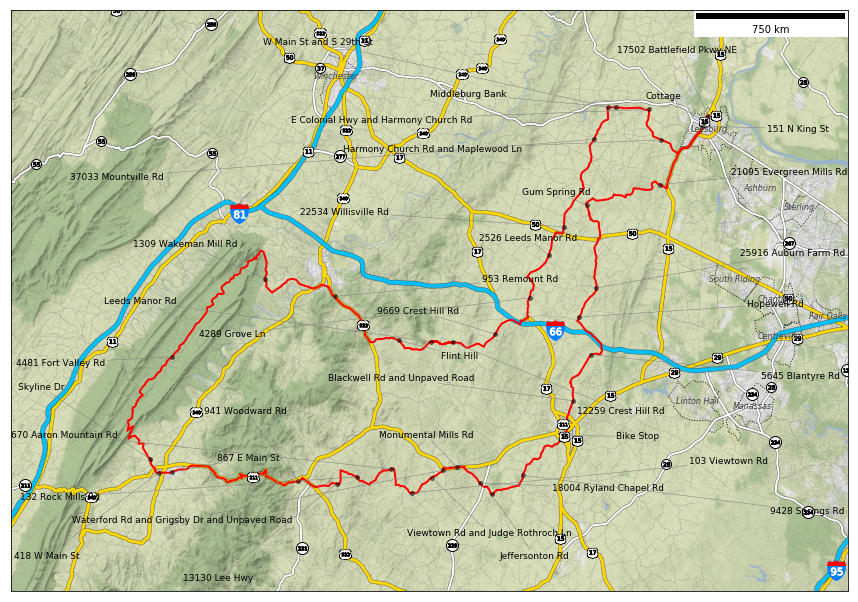

In [376]:
ax = plot_df.plot(
    figsize=(15, 15),
    alpha=0.5,
    edgecolor='black',
    color='black',
    linewidth=1,
    markersize=15,
    zorder=2.9,
)

ax.plot(
    gmaps_gdf.geometry.x, 
    gmaps_gdf.geometry.y, 
#     'o-',
    zorder=2,
    linewidth=2,
    color='red',
#     alpha=0.5,
    markersize=0,
)

interstate_gdf = roads_gdf_2.loc[(roads_gdf_2.geometry.apply(lambda x: x.intersects(box))),].loc[
      (roads_gdf_2['class'] == 'Interstate')
]

federal_gdf = roads_gdf_2.loc[(roads_gdf_2.geometry.apply(lambda x: x.intersects(box))),].loc[
      (roads_gdf_2['class'] == 'Federal')
]

state_gdf = roads_gdf_2.loc[(roads_gdf_2.geometry.apply(lambda x: x.intersects(box))),].loc[
      (roads_gdf_2['class'] == 'State')
]

interstate_gdf.plot(
    ax=ax,
    linewidth=4,
    color='deepskyblue',
    zorder=2,
#     alpha=1,
)

interstate_gdf.plot(
    ax=ax,
    linewidth=5,
    color='black',
    zorder=1.9,
    alpha=0.5,
)

federal_gdf.plot(
    ax=ax,
    linewidth=3,
    color='gold',
    zorder=1.8,
#     alpha=0.5,
)

federal_gdf.plot(
    ax=ax,
    linewidth=4,
    color='black',
    zorder=1.7,
    alpha=0.5,
)

state_gdf.plot(
    ax=ax,
    linewidth=2,
    color='white',
    zorder=1.6,
#     alpha=0.5,
)

state_gdf.plot(
    ax=ax,
    linewidth=3,
    color='black',
    zorder=1.5,
    alpha=0.5,
)

places_plot = places_gdf.loc[(places_gdf.geometry.apply(lambda x: x.within(box))),]
places_plot = places_plot.sort_values("TOTAL_POPU", ascending=False).head(10)
places_plot['centroid'] = places_plot['geometry'].centroid
places_plot.plot(
    ax=ax,
    linewidth=1,
    color='none',
    zorder=1.3,
    alpha=0.8,
    linestyle="dotted",
    edgecolor='black',
)

[plt.text(row['centroid'].x, row['centroid'].y, row['NAME'].split(",")[0], size=8, color='#454545',  style='italic', ha='center',
         ) for n, row in places_plot.iterrows()]

small_road_gdf.plot(
    ax=ax,
    linewidth=0.1,
    color='grey',
    zorder=1.2,
#     alpha=0.8,
#     linestyle="dotted",
#     edgecolor='grey',
)

ax.set_xlim(box.bounds[0], box.bounds[2])
ax.set_ylim(box.bounds[1], box.bounds[3])

xy = [get_middle_xy(row['geometry'], box) for n, row in state_gdf.loc[
    (state_gdf['number'].str.len()==2) &
    (state_gdf['length']>5) &
    (state_gdf['uident']!=22411)
].iterrows()]
x = [n[0] for n in xy]
y = [n[1] for n in xy]
nums = [row['number'] for n, row in state_gdf.loc[
    (state_gdf['number'].str.len()==2) &
    (state_gdf['length']>5) &
    (state_gdf['uident']!=22411)
].iterrows()]
plt.plot(x, y, marker='o', markersize=10, color='black', linewidth=0)
plt.plot(x, y, marker='o', markersize=8, color='white', linewidth=0)
for x0, y0, num in zip(x, y, nums):
    plt.plot(x0, y0*(1), marker=f"${num}$", markersize=7, color='black', linewidth=0)    
    
xy = [get_middle_xy(row['geometry'], box) for n, row in state_gdf.loc[
    (state_gdf['number'].str.len()==3) &
    (state_gdf['length']>5)
].iterrows()]
x = [n[0] for n in xy]
y = [n[1] for n in xy]
nums = [row['number'] for n, row in state_gdf.loc[
    (state_gdf['number'].str.len()==3) &
    (state_gdf['length']>5)
].iterrows()]
plt.plot(x, y, marker='o', markersize=12, color='black', linewidth=0)
plt.plot(x, y, marker='o', markersize=10, color='white', linewidth=0)
for x0, y0, num in zip(x, y, nums):
    plt.plot(x0, y0*(1), marker=f"${num}$", markersize=9, color='black', linewidth=0)    

xy = [get_middle_xy(row['geometry'], box) for n, row in federal_gdf.loc[
    (federal_gdf['number'].str.len()==2) & 
    (federal_gdf['length']>5)
].iterrows()]
x = [n[0] for n in xy]
y = [n[1] for n in xy]
nums = [row['number'] for n, row in federal_gdf.loc[
    (federal_gdf['number'].str.len()==2) & 
    (federal_gdf['length']>5)
].iterrows()]
plt.plot(x, y, marker=federal, markersize=12, color='black', linewidth=0)
plt.plot(x, y, marker=federal, markersize=10, color='white', linewidth=0)
for x0, y0, num in zip(x, y, nums):
    plt.plot(x0, y0*(1), marker=f"${num}$", markersize=7, color='black', linewidth=0)    
    
xy = [get_middle_xy(row['geometry'], box) for n, row in federal_gdf.loc[
    (federal_gdf['number'].str.len()==3) & 
    (federal_gdf['length']>2.5)
].iterrows()]
x = [n[0] for n in xy]
y = [n[1] for n in xy]
nums = [row['number'] for n, row in federal_gdf.loc[
    (federal_gdf['number'].str.len()==3) &
    (federal_gdf['length']>2.5)
].iterrows()]
plt.plot(x, y, marker=federal_wide, markersize=12, color='black', linewidth=0)
plt.plot(x, y, marker=federal_wide, markersize=10, color='white', linewidth=0)
for x0, y0, num in zip(x, y, nums):
    plt.plot(x0, y0*(1), marker=f"${num}$", markersize=8, color='black', linewidth=0)    

xy = [get_middle_xy(row['geometry'], box) for n, row in interstate_gdf.iterrows()]
x = [n[0] for n in xy]
y = [n[1] for n in xy]
nums = [row['number'] for n, row in interstate_gdf.iterrows()]
# ax.scatter(x, y) 
bboxes = []
# for x0, y0, num in zip(x, y, nums):
#     path = create_road_sign("interstate", num)
#     ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
#     bboxes.append(ab)
#     ab.set_zorder(2.1)
#     ax.add_artist(ab)   

plt.plot(x, y, marker=interstate, markersize=30, color='#007fff', linewidth=0)
plt.plot(x, [z*(1.000115) for z in y], marker=interstate2, markersize=18, color='red', linewidth=0)

for x0, y0, num in zip(x, y, nums):
    plt.plot(x0, y0*(0.99977), marker=f"${num}$", markersize=12, color='white', linewidth=0)
    
texts = []
texts += [plt.text(row['geometry'].x, row['geometry'].y, row['name'], size=9) for n, row in plot_df.iterrows()] # weight = 'bold'
# texts += [plt.text(*get_middle_xy(row['geometry'], box), row['number'], size=7) for n, row in df.iterrows()]
adjust_text(texts, add_objects = bboxes, precision = 0.02, expand_points  = (2, 2), expand_text = (2.5, 2.5), expand_objects = (2, 2), lim = 2500, force_text = (0.5, 1), 
            arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
add_basemap(ax, zoom=12, url=ctx.sources.ST_TERRAIN_BACKGROUND)

miles = Point(box.bounds[0],box.bounds[1]).distance(Point(box.bounds[2],box.bounds[1]))*0.000621371
x_px = 3500
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_facecolor('honeydew')
scalebar = ScaleBar(miles/x_px ,  'km')
plt.gca().add_artist(scalebar)

plt.savefig('test5.svg',  dpi=300, bbox_inches = "tight", pad_inches = -0.015)
plt.savefig('test5.png',  dpi=300, bbox_inches = "tight", pad_inches = -0.015)
plt.show()

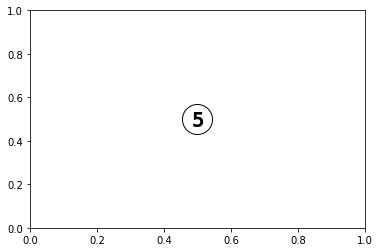

In [271]:
from svgpath2mpl import parse_path

import matplotlib.pyplot as plt      
import numpy as np            
import matplotlib
font = ImageFont.truetype('highway_gothic/hwygoth.ttf', size=10)
smiley = parse_path("""M303.8720703,28.0273438l50.3662109,52.1557617    C339.7480469,97.5253906,331,119.8857422,331,144.2758789c0,20.8432617,6.4052734,40.2626953,17.3476563,56.3041992    C357.5654297,214.0683594,363,230.4316406,363,248c0,46.2294922-37.3447266,83.7363281-83.5097656,83.9990234    C247.1210938,332.0214844,217.1582031,341.6162109,192,358.0605469c-25.1884766-16.4648438-55.1953125-26.0625-87.609375-26.0625    C58.2797852,331.6728516,21,294.1904297,21,248c0-17.5673828,5.4345703-33.9316406,14.6523438-47.4199219    C46.5942383,184.5385742,53,165.1191406,53,144.2758789c0-24.390625-8.7480469-46.7504883-23.2382813-64.0927734    l50.3662109-52.1557617C96.0566406,37.9365234,114.8740234,43.6699219,135,43.6699219c21.0283203,0,40.6298828-6.2587891,57-17    c16.3701172,10.7412109,35.9716797,17,57,17C269.1259766,43.6699219,287.9433594,37.9365234,303.8720703,28.0273438z     M249,31.6699219c21.2548828,0,40.8378906-7.2177734,56.4121094-19.3222656l65.4033203,67.7265625    C353.7060547,96.1201172,343,118.9477539,343,144.2758789c0,18.3544922,5.6318359,35.425293,15.2578125,49.5375977    C368.7890625,209.2226563,375,227.9277344,375,248c0,52.8339844-42.6796875,95.6992188-95.4414063,95.9980469    c-32.8427734,0.0117188-62.9824219,10.65625-87.5585938,28.6523438    c-24.5898438-18.0048828-54.7475586-28.6523438-87.609375-28.6523438C51.6513672,343.671875,9,300.8164063,9,248    c0-20.0722656,6.2109375-38.7773438,16.7421875-54.1865234C35.3681641,179.7011719,41,162.6303711,41,144.2758789    c0-25.328125-10.706543-48.1557617-27.8154297-64.2016602l65.4033203-67.7265625    C94.1621094,24.4521484,113.7451172,31.6699219,135,31.6699219c21.5219727,0,41.3310547-7.3989258,57-19.7802734    C207.6689453,24.2709961,227.4775391,31.6699219,249,31.6699219z""")
smiley = smiley.transformed(matplotlib.transforms.Affine2D().rotate_deg(180))
smiley.vertices -= smiley.vertices.mean(axis=0)     

plt.plot([0.5], [0.5], marker='o', markersize=30, color='black', linewidth=0)
plt.plot([0.5], [0.5], marker='o', markersize=28, color='white', linewidth=0)
# plt.plot([0.5], [0.5*0.998], marker=federal, markersize=25, color='white', linewidth=0)
# plt.plot([0.5], [0.52], marker=path2, markersize=16.5, color='red', linewidth=0)
plt.plot([0.49725], [0.5], marker=f"$5$", markersize=14, color='black', linewidth=0,)
plt.xlim([0, 1]) 
plt.ylim([0, 1]) 
plt.savefig("test_image.svg")
plt.show()

In [205]:
federal_gdf = roads_gdf_2.loc[(roads_gdf_2.geometry.apply(lambda x: x.intersects(box))),].loc[
      (roads_gdf_2['class'] == 'Federal')
]
federal_gdf

,prefix,number,class,type,divided,country,state,note,scalerank,uident,length,rank,continent,geometry
18836,US,340,Federal,Primary,Undivided,United States,West Virginia,None,7,18848,12.589800,0,North America,LINESTRING (-8674006.393553156 4749095.4378446...
18840,US,50,Federal,Primary,Undivided,United States,West Virginia,None,7,18852,138.258000,0,North America,LINESTRING (-8832838.105447695 4763769.5874706...
21854,US,11,Federal,Other Paved,None,United States,Virginia,None,9,21867,1.524590,0,North America,LINESTRING (-8701391.824813852 4748419.8469402...
21856,US,15,Federal,Other Paved,None,United States,Virginia,None,6,21869,5.301520,0,North America,LINESTRING (-8659296.563817553 4678392.2421860...
21857,US,15,Federal,Other Paved,None,United States,Virginia,None,9,21870,6.337000,0,North America,LINESTRING (-8632467.487943813 4741786.3455795...
21891,US,522,Federal,Other Paved,None,United States,Virginia,None,8,21904,0.160670,0,North America,LINESTRING (-8700856.138976876 4749626.6084985...
21996,US,1,Federal,Secondary,Undivided,United States,Virginia,None,9,22009,37.184900,0,North America,LINESTRING (-8624135.936839469 4624555.8031454...
22009,US,11,Federal,Secondary,Undivided,United States,Virginia,None,8,22022,18.779700,-1,North America,LINESTRING (-8701071.446789166 4748293.1786793...
22010,US,11,Federal,Secondary,Undivided,United States,Virginia,None,9,22023,82.993200,0,North America,LINESTRING (-8719875.569883261 4722966.9974584...
22011,US,11,Federal,Secondary,Undivided,United States,Virginia,None,9,22024,32.458800,-1,North America,LINESTRING (-8719875.569883261 4722966.9974584...


In [13]:
places_gdf = gp.read_file("places/places.shp")

if places_gdf.crs['init']!= 'epsg:3857':
    places_gdf = places_gdf.to_crs(epsg=3857)
    places_gdf.to_file("places/places.shp")

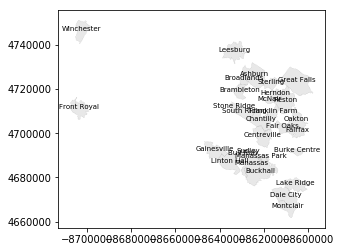

In [751]:
places_plot = places_gdf.loc[(places_gdf.geometry.apply(lambda x: x.intersects(box))),]
places_plot = places_plot.sort_values("TOTAL_POPU", ascending=False).head(30)
places_plot['centroid'] = places_plot['geometry'].centroid
places_plot.plot(
    linewidth=0.5,
    color='lightgrey',
    zorder=1.3,
    alpha=0.5,
    linestyle="dotted",
    edgecolor='grey',
)

[plt.text(row['centroid'].x, row['centroid'].y, row['NAME'].split(",")[0], size=7, ha='center') for n, row in places_plot.iterrows()]

plt.show()

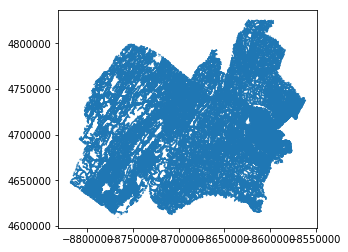

In [75]:
small_road_gdf.plot()

In [14]:
counties_gdf = gp.read_file("counties/counties.shp")

if counties_gdf.crs['init']!= 'epsg:3857':
    counties_gdf = counties_gdf.to_crs(epsg=3857)
    counties_gdf.to_file("counties/counties.shp")

In [15]:
counties_gdf_plot = counties_gdf.loc[(counties_gdf.geometry.apply(lambda x: x.intersects(box))),]

In [16]:
counties_gdf_plot

,GEO_ID,NAME,TOTAL_POPU,geometry
62,51600,"Fairfax city, Virginia",23865,POLYGON ((-8608876.345213173 4700742.255123577...
266,51840,"Winchester city, Virginia",27789,POLYGON ((-8705239.505820917 4747511.331142932...
894,51685,"Manassas Park city, Virginia",16423,POLYGON ((-8624935.406274501 4690529.290035497...
896,51683,"Manassas city, Virginia",41457,"POLYGON ((-8630228.425422739 4683526.6402295, ..."
1011,24021,"Frederick County, Maryland",255648,"POLYGON ((-8640637.79968733 4791339.705088571,..."
1035,24031,"Montgomery County, Maryland",1052567,POLYGON ((-8619636.041915288 4754983.138056745...
1681,51107,"Loudoun County, Virginia",406850,POLYGON ((-8622470.570109358 4732190.809571253...
1697,51179,"Stafford County, Virginia",149960,"POLYGON ((-8637143.8148298 4650877.078198858, ..."
1699,51059,"Fairfax County, Virginia",1150795,(POLYGON ((-8619712.852363937 4714894.65140113...
1700,51061,"Fauquier County, Virginia",70675,POLYGON ((-8662922.291951781 4718953.214971446...


In [46]:
from zipfile import ZipFile
from urllib.request import urlopen
import os
file_dir = "small_roads"
for geo_id in counties_gdf_plot.GEO_ID:
    if path.exists(f"{file_dir}/tl_2019_{geo_id}_roads/tl_2019_{geo_id}_roads.shp"):
        continue
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/ROADS/tl_2019_{geo_id}_roads.zip'
        # Download the file from the URL
    zipresp = urlopen(url)
        # Create a new file on the hard drive
    tempzip = open("/tmp/tempfile.zip", "wb")
        # Write the contents of the downloaded file into the new file
    tempzip.write(zipresp.read())
        # Close the newly-created file
    tempzip.close()
        # Re-open the newly-created file with ZipFile()
    zf = ZipFile("/tmp/tempfile.zip")
        # Extract its contents into <extraction_path>
        # note that extractall will automatically create the path
    zf.extractall(path = os.path.abspath(f'{file_dir}/tl_2019_{geo_id}_roads'))
        # close the ZipFile instance
    zf.close()

In [70]:
def open_and_convert_crs(file_path):
    temp_gdf = gp.read_file(file_path)
    if temp_gdf.crs['init']!= 'epsg:3857':
        temp_gdf = temp_gdf.to_crs(epsg=3857)
        temp_gdf.to_file(file_path)
    return temp_gdf

In [73]:
small_road_gdf = gp.GeoDataFrame()
for small_road_file in os.listdir(file_dir):
    for shape_file in os.listdir(f'{file_dir}/{small_road_file}'):
        if shape_file.endswith(".shp"):
            small_road_gdf = small_road_gdf.append(open_and_convert_crs(f'{file_dir}/{small_road_file}/{shape_file}'), ignore_index=True)

In [747]:
for route in gpx.waypoints:
    print(route)

[wpt{..}:39.20826676301658,-77.37732765264809@None]
[wpt{018}:39.507683012634516,-77.6528487727046@None]
[wpt{019}:39.12841857410967,-77.57109462283552@None]
[wpt{030}:39.10990621894598,-77.8351787198335@None]
[wpt{031}:38.9964949619025,-77.74602318182588@None]
[wpt{044}:38.965860195457935,-77.7345242165029@None]
[wpt{052}:39.34160473756492,-78.18550396710634@None]
[wpt{055}:39.65645810589194,-77.85217629745603@None]
[wpt{056}:39.69414641149342,-77.78885068371892@None]
[wpt{060}:39.416109044104815,-77.30240114964545@None]
[wpt{067}:39.16462345048785,-77.51932279206812@None]
[wpt{081}:39.53899797052145,-77.15682500973344@None]
[wpt{082}:39.430618789047,-77.28869740851223@None]
[wpt{083}:39.5529346447438,-77.06286940723658@None]
[wpt{084}:39.37552101910114,-77.31121128425002@None]
[wpt{085}:39.43592369556427,-77.18811750411987@None]
[wpt{086}:39.439536379650235,-77.22668373025954@None]
[wpt{100 E Campus Dr}:39.43315029144287,-77.80569076538086@None]
[wpt{104 Tyson Dr}:39.15150082670152,-